In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data
from scipy import signal, stats
import mne
from tkinter import *

print(tf.__version__)

1.14.0


### EEG Data

https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html

EEG channels in the data follow the 10-20 system https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)


Map of EEG Electrode positions. Channels from the dataset are yellow:
![](eeg_map.png)


Muselsl lists the Muse's eeg channels as: Tp9, AF7, AF8, Tp10, but these are not covered by the data

**The closest channels in the dataset are:**
- *Tp9*: T7(8), P7(12)
- *AF7*: F7(4), Fp1(1), AF3(2)
- *AF8*: F8(21), Fp2(17), AF4(18)
- *Tp10*: T8(26), P8(30)

In the future, it might be beneficial to blend between these channels to get a better approximation of the Muse's channels.

Right now we'll just use the first nearby channel for each.
This means we need to take the data at indices 7, 3, 20 and 25


**Important!** Make sure the Muse input order matches the dataset training order when it is used.


In [2]:
# We'll use the data channels in these indices
# Note: subtract 1 from the channel number listed on the website
featureIndices = [7,3,20,25] #[T7, F7, F8, T8]

In [3]:
dataPath = "data"
dataFiles = os.listdir(dataPath)

print(dataFiles)

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [4]:
# Load the data

labels = np.empty((0,4), dtype=np.float32)
data = np.empty((0,40,8064), dtype=np.float32)

for file in dataFiles[:]:
    filePath = os.path.join(dataPath, file)
    fileData = np.load(filePath, encoding='bytes', allow_pickle=True)
    labels = np.append(labels, fileData[b'labels'], axis=0)
    data = np.append(data, fileData[b'data'], axis=0)
    
print(labels.shape)
print(data.shape)

(1280, 4)
(1280, 40, 8064)


In [30]:
# Separate out the features and targets we want to train our network on

features = data[:, featureIndices]
targets = labels[:, 0:3] # Valence, arousal, dominance

print(features.shape)
print(targets.shape)

(1280, 4, 8064)
(1280, 3)


In [9]:
from scipy import stats
# Some statistics about our features

print("T7:\n{}\n".format(stats.describe(features[:,0], axis=None)))
print("F7:\n{}\n".format(stats.describe(features[:,1], axis=None)))
print("F8:\n{}\n".format(stats.describe(features[:,2], axis=None)))
print("T8:\n{}\n".format(stats.describe(features[:,3], axis=None)))


T7:
DescribeResult(nobs=10321920, minmax=(-776.0792293949434, 857.2720367832355), mean=0.01422301211877041, variance=643.5647627640747, skewness=-0.8343172191415963, kurtosis=45.616619392377366)

F7:
DescribeResult(nobs=10321920, minmax=(-2656.4252330049085, 2843.9056801961733), mean=0.009937458226432836, variance=2666.957155074334, skewness=-0.46793838396858534, kurtosis=126.10387741129793)

F8:
DescribeResult(nobs=10321920, minmax=(-1324.8027976969654, 1392.8027055588925), mean=-0.004317137802204071, variance=977.4762034297689, skewness=0.7260787712754011, kurtosis=97.9925906726572)

T8:
DescribeResult(nobs=10321920, minmax=(-1327.8695540040417, 1781.5512349522496), mean=0.027424162279529773, variance=1439.7588622220019, skewness=1.3809555212954843, kurtosis=132.22846477905748)



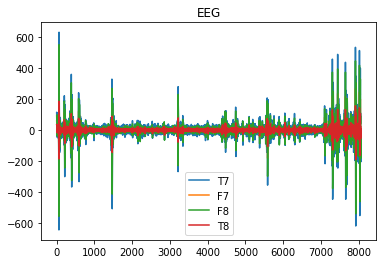

array([1.  , 1.  , 5.04])

In [53]:
# Let's take a look at some of out EEG data
index = 60

plt.title("EEG")
plt.plot(features[index,0,:], label="T7")
plt.plot(features[index,1,:], label="F7")
plt.plot(features[index,2,:], label="F8")
plt.plot(features[index,3,:], label="T8")
plt.legend()
plt.show()

targets[index]

In [59]:
# inefficient, but it works
def SegmentData(data, newLen):
    segments = int(data.shape[2] / newLen)
    newSamples = data.shape[0] * segments
    newData = np.empty((newSamples, data.shape[1], newLen))
    i = 0
    for sample in data:
        for seg in range(segments):
            for dim in range(data.shape[1]):
                newData[i][dim] = sample[dim][seg*newLen:(seg+1)*newLen]
            i += 1
    return newData

def Duplicate(data, repetitions):
    newData = np.empty((data.shape[0]*repetitions, data.shape[1]))
    for i in range(data.shape[0]):
        for rep in range(repetitions):
            newData[i*repetitions + rep] = data[i]
    return newData

# Divide the dataset into roughly 10-second segments
# Note: data is 63 seconds (baseline?) and must evenly divide into segments
sampleRate = 128
sampleTime = 10.5
desiredSamples = int(sampleRate * sampleTime)
segments = int(features.shape[2] / desiredSamples)

resampledFeatures = SegmentData(features, desiredSamples)
print(resampledFeatures.shape)

resampledTargets = Duplicate(targets, segments)
print(resampledTargets.shape)

(7680, 4, 1344)
(7680, 3)


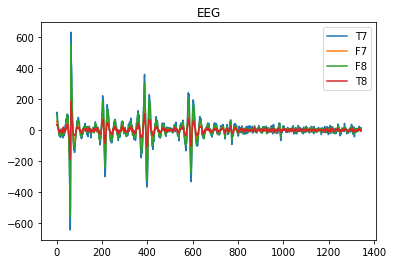

array([1.  , 1.  , 5.04])

In [241]:
# Let's take a look at some of out EEG data
index = 360

plt.title("EEG")
plt.plot(resampledFeatures[index,0], label="T7")
plt.plot(resampledFeatures[index,1], label="F7")
plt.plot(resampledFeatures[index,2], label="F8")
plt.plot(resampledFeatures[index,3], label="T8")
plt.legend()
plt.show()

resampledTargets[index]

In [65]:
# Separate data into training and validation sets
valPercent = 30
valCount = (valPercent * len(resampledTargets)) // 100

shuffle = np.arange(len(resampledTargets))
np.random.shuffle(shuffle)

if valCount >= 1:
    testSlice = shuffle[:-valCount]
    valSlice = shuffle[-valCount:]
else:
    testSlice = shuffle
    valSlice = []
    
trainFeatures = resampledFeatures[testSlice]
trainTargets = resampledTargets[testSlice]

valFeatures = resampledFeatures[valSlice]
valTargets = resampledTargets[valSlice]

print(trainFeatures.shape, trainTargets.shape)
print(valFeatures.shape, valTargets.shape)

(5376, 4, 1344) (5376, 3)
(2304, 4, 1344) (2304, 3)


In [161]:
# Define the Network

"""
# Old model using full 63 seconds of data
model = keras.models.Sequential()

#Convolution
model.add(keras.layers.Reshape((40, 8064, 1), input_shape=(40, 8064)))
model.add(keras.layers.Conv2D(32, (1, 4), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,2), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,2), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 64), strides=(1,2), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))

#Dense and output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))
"""

# New model using resampled data
model = keras.models.Sequential()

#Convolution
model.add(keras.layers.Reshape((4, desiredSamples, 1), input_shape=(4, desiredSamples)))
model.add(keras.layers.Conv2D(32, (1, 4), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 64), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))

#Dense and output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 4, 1344, 1)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 4, 1341, 32)       160       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 4, 670, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 4, 663, 64)        16448     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 4, 331, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 4, 324, 64)        32832     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 4, 162, 64)      

In [162]:
#Compile and train the network

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error'])

history = model.fit(trainFeatures, trainTargets, epochs=20, batch_size=None, 
                    validation_data=(valFeatures, valTargets))


Train on 5376 samples, validate on 2304 samples
Epoch 1/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 47.4518 - mean_absolute_error: 2.8207 - val_loss: 5.4637 - val_mean_absolute_error: 1.9441
Epoch 2/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 4.6789 - mean_absolute_error: 1.7892 - val_loss: 4.4159 - val_mean_absolute_error: 1.7539
Epoch 3/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 4.3281 - mean_absolute_error: 1.7343 - val_loss: 4.3016 - val_mean_absolute_error: 1.7325
Epoch 4/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 4.3351 - mean_absolute_error: 1.7350 - val_loss: 4.2946 - val_mean_absolute_error: 1.7317
Epoch 5/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 4.2716 - mean_absolute_error: 1.7233 - val_loss: 4.2704 - val_mean_absolute_error: 1.7241
Epoch 6/20
5376/5376 [==============================] - 11s 2ms/sample - loss: 4.2721 - mean_absolute_erro

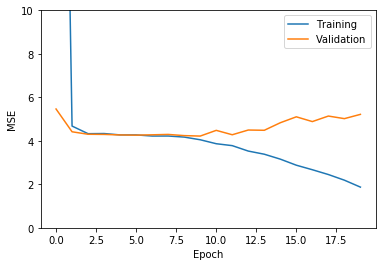

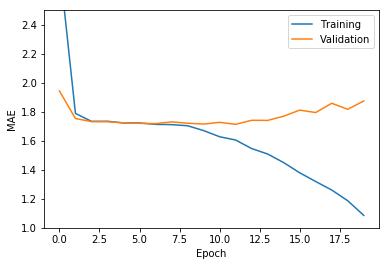

In [168]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 10])
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['mean_absolute_error'], label='Training')
plt.plot(history.history['val_mean_absolute_error'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim([1, 2.5])
plt.legend(loc='upper right')
plt.show()

In [103]:
# Get Some example output
sampleX = valFeatures[:10]
sampleY = valTargets[:10]

pred = model.predict(sampleX)

print("\t\t Pred | Real | Diff")
for i in range(len(pred)):
    print("========================================")
    print("Valence\t\t {:.2f} | {:.2f} | {:.2f} ".format(pred[i][0], sampleY[i][0], abs(pred[i][0] - sampleY[i][0])))
    print("Arousal\t\t {:.2f} | {:.2f} | {:.2f} ".format(pred[i][1], sampleY[i][1], abs(pred[i][1] - sampleY[i][1])))
    print("Dominance\t {:.2f} | {:.2f} | {:.2f} ".format(pred[i][2], sampleY[i][2], abs(pred[i][2] - sampleY[i][2])))
   

		 Pred | Real | Diff
Valence		 5.07 | 6.13 | 1.06 
Arousal		 5.23 | 5.97 | 0.74 
Dominance	 4.87 | 8.49 | 3.62 
Valence		 5.07 | 3.99 | 1.08 
Arousal		 4.87 | 7.17 | 2.30 
Dominance	 5.01 | 4.85 | 0.16 
Valence		 5.25 | 5.76 | 0.51 
Arousal		 4.84 | 4.78 | 0.06 
Dominance	 5.24 | 3.78 | 1.46 
Valence		 5.45 | 6.96 | 1.51 
Arousal		 4.90 | 3.92 | 0.98 
Dominance	 5.45 | 7.19 | 1.74 
Valence		 8.64 | 3.97 | 4.67 
Arousal		 12.60 | 6.04 | 6.56 
Dominance	 6.61 | 5.09 | 1.52 
Valence		 5.04 | 3.31 | 1.73 
Arousal		 5.04 | 4.45 | 0.59 
Dominance	 5.06 | 6.23 | 1.17 
Valence		 6.08 | 9.00 | 2.92 
Arousal		 6.84 | 8.32 | 1.48 
Dominance	 5.75 | 8.06 | 2.31 
Valence		 5.22 | 4.05 | 1.17 
Arousal		 4.77 | 3.83 | 0.94 
Dominance	 5.19 | 5.50 | 0.31 
Valence		 5.40 | 4.04 | 1.36 
Arousal		 4.92 | 9.00 | 4.08 
Dominance	 5.34 | 7.08 | 1.74 
Valence		 5.20 | 8.04 | 2.84 
Arousal		 5.21 | 6.99 | 1.78 
Dominance	 5.07 | 5.01 | 0.06 


In [105]:
#Save the model in its current form
model.save("EmotionNetV2.h5")

In [2]:
#load model
model = keras.models.load_model("EmotionNetV2.h5")

W1213 09:53:18.719309 1134512 deprecation.py:506] From D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1213 09:53:18.721309 1134512 deprecation.py:506] From D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1213 09:53:18.723315 1134512 deprecation.py:506] From D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tenso

In [3]:
# Setup input buffer

fs = 256
inputLength = 10.5 # Length of input in seconds
shiftLength = 5 # Time between epochs
samples = int(shiftLength * fs) # How many samples to gather in every cycle
print(samples)

bufferSize = int(128 * inputLength) # Size of buffer in samples. Enough to hold one set of downsampled input.

buffers = np.zeros((4, bufferSize)) # buffers for each of the four channels

# Push new data onto buffer, removing any old data on the end
def updateBuffer(buffer, newData):
    assert len(newData.shape) == len(buffer.shape) and buffer.shape[0] >= newData.shape[0], "Buffer shape ({}) and new data shape ({}) are not compatible.".format(buffer.shape, newData.shape)
    size = newData.shape[0]
    buffer[:-size] = buffer[size:]
    buffer[-size:] = newData
    return buffer

1280


Looking for an EEG stream...
Start acquiring data
Stream connected.
Sampling frequency: 256 points per second
Processing Muse EEG data...

Got 1270 samples in 5.00331 seconds
Resampled to 635


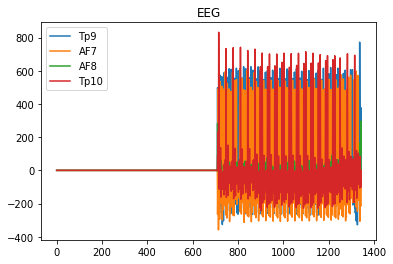

Got 1280 samples in 4.74947 seconds
Resampled to 640


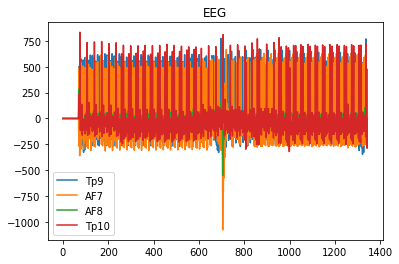

Got 1280 samples in 4.77157 seconds
Resampled to 640


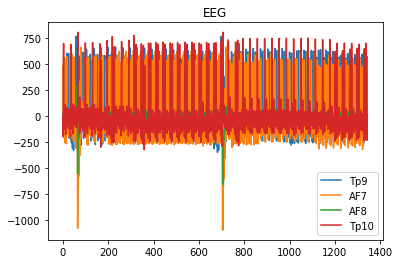

Got 1280 samples in 4.69914 seconds
Resampled to 640


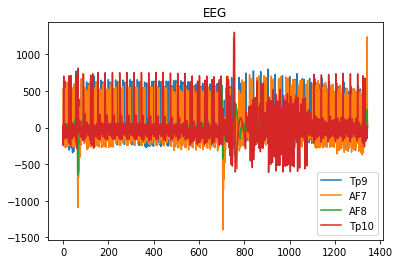

Got 1280 samples in 4.75136 seconds
Resampled to 640


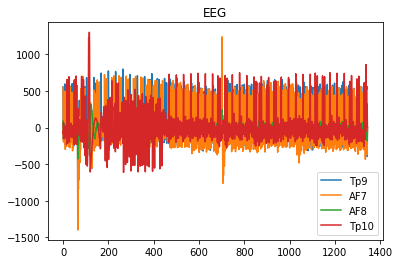

Got 1280 samples in 4.75224 seconds
Resampled to 640


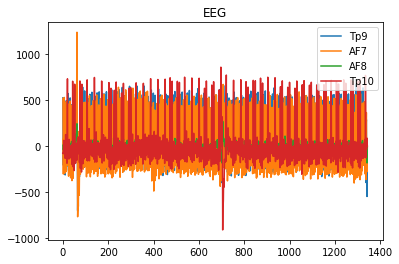

Got 1280 samples in 4.67508 seconds
Resampled to 640


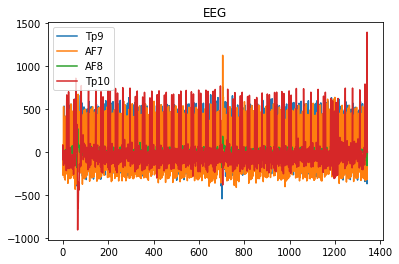

Got 1280 samples in 4.71579 seconds
Resampled to 640


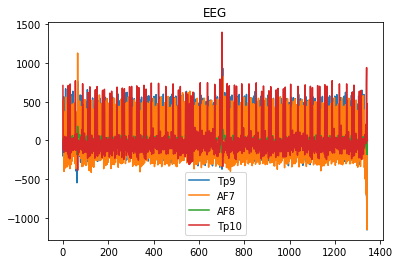

Got 1280 samples in 4.76731 seconds
Resampled to 640


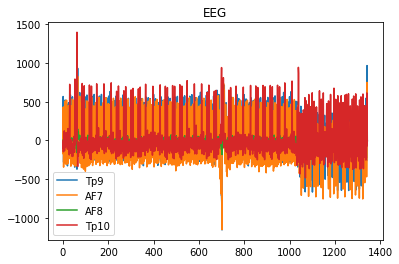

Got 1280 samples in 4.72640 seconds
Resampled to 640


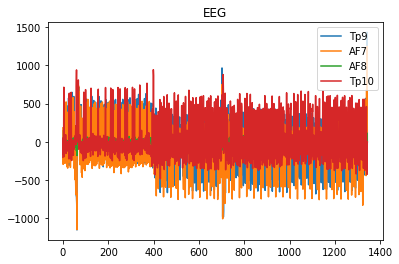

END


In [40]:
# Get the streamed data from the Muse. Blue Muse must be streaming.

print('Looking for an EEG stream...')
streams = resolve_byprop('type', 'EEG', timeout=2)
if len(streams) == 0:
    raise RuntimeError('Can\'t find EEG stream.')
    

# Set active EEG stream to inlet and apply time correction
print("Start acquiring data")
inlet = StreamInlet(streams[0], max_buflen=60, max_chunklen=int(inputLength))
eeg_time_correction = inlet.time_correction()

# Get the stream info and description
info = inlet.info()
description = info.desc()

# Get the sampling frequency
# This is an important value that represents how many EEG data points are
# collected in a second. This influences our frequency band calculation.
# for the Muse 2016, this should always be 256
fs = int(info.nominal_srate())

print("Stream connected.")
print("Sampling frequency: {} points per second".format(fs))

# Begin processing EEG data
print("Processing Muse EEG data...\n")

import time

for i in range(10):
    
    start = time.time()
    data, timestamp = inlet.pull_chunk(timeout=5, max_samples=samples)
    t = time.time() - start
    print("Got {} samples in {:.5f} seconds".format(len(data), t))
    eeg = np.array(data).swapaxes(0,1)
    
    """
    The DEAP dataset has 3 processing steps which we must also apply to out data:
        1. downsample to 128 Hz.
        2. Apply a bandpass frequency filter from 4-45 Hz
        3. Average data to the common reference
    """
    
    # Downsample
    processedEEG = signal.resample(eeg, int(eeg.shape[1] * (128 / fs)), axis=1)
    print("Resampled to {}".format(processedEEG.shape[1]))
    
    # Apply bandpass filter from 4-45Hz
    processedEEG = mne.filter.band_pass_filter(processedEEG, 128, 4, 45, filter_length=512, 
                                       l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                       phase='zero', fir_window='hamming', verbose=0)
    
    # Zero mean
    processedEEG -= np.mean(processedEEG, axis=1, keepdims=True)
    
    # Update buffer
    for channel in range(buffers.shape[0]):
        buffers[channel] = updateBuffer(buffers[channel], processedEEG[channel])
    
    #print(model.predict([[processedEEG]]))
    plt.title("EEG")
    plt.plot(buffers[0], label="Tp9")
    plt.plot(buffers[1], label="AF7")
    plt.plot(buffers[2], label="AF8")
    plt.plot(buffers[3], label="Tp10")
    plt.legend()
    plt.show()
print("END")
    
inlet.close_stream()

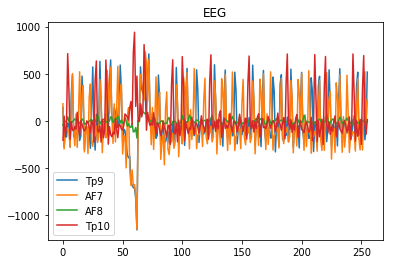

array([2, 2, 3, 4, 4])

In [160]:
plt.title("EEG")
plt.plot(buffers[0,:256], label="Tp9")
plt.plot(buffers[1,:256], label="AF7")
plt.plot(buffers[2,:256], label="AF8")
plt.plot(buffers[3,:256], label="Tp10")
plt.legend()
plt.show()



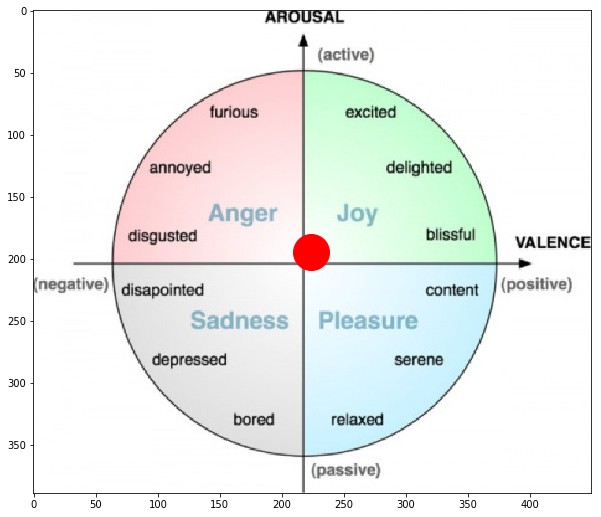

Valence: 5.14
Arousal: 5.19
Dominance: 4.93


KeyboardInterrupt: 

In [6]:
from IPython.display import clear_output

# Get the streamed data from the Muse. Blue Muse must be streaming.
streams = resolve_byprop('type', 'EEG', timeout=2)
if len(streams) == 0:
    raise RuntimeError('Can\'t find EEG stream.')

# Set active EEG stream to inlet and apply time correction
inlet = StreamInlet(streams[0], max_buflen=60, max_chunklen=int(inputLength))
eeg_time_correction = inlet.time_correction()

# Get the stream info and description
info = inlet.info()
description = info.desc()

# Get the sampling frequency
fs = int(info.nominal_srate())


# Important info for plot
img = plt.imread("EmotionSpace.jpg")
width = img.shape[1]
height = img.shape[0]
centerX = int(width / 2) -8
centerY = int(height / 2) +8
pixPerValence = centerX / 5
pixPerArousal = centerY / 5

try:
    while True:
        # Continuously update EEG data and attempt to measure emotions
        
        data, timestamp = inlet.pull_chunk(timeout=5, max_samples=samples)
        eeg = np.array(data).swapaxes(0,1)

        """
        The DEAP dataset has 3 processing steps which we must also apply to out data:
        1. downsample to 128 Hz.
        2. Apply a bandpass frequency filter from 4-45 Hz
        3. Average data to the common reference
        """

        # Downsample
        processedEEG = signal.resample(eeg, int(eeg.shape[1] * (128 / fs)), axis=1)

        # Apply bandpass filter from 4-45Hz
        processedEEG = mne.filter.band_pass_filter(processedEEG, 128, 4, 45, filter_length=512, 
                                       l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                       phase='zero', fir_window='hamming', verbose=0)

        # Zero mean
        processedEEG -= np.mean(processedEEG, axis=1, keepdims=True)

        # Update buffer
        for channel in range(buffers.shape[0]):
            buffers[channel] = updateBuffer(buffers[channel], processedEEG[channel])
        
        # perform emotion regression analysis
        emotions = model.predict([[buffers]])
        # Clip results in case they have outliers
        emotions = np.clip(emotions, 1, 9)
        
        valence = emotions[0][0]
        arousal = emotions[0][1]
        dominance = emotions[0][2]
        
        
        # Calculate Emotion Display and plot the graph
        x = valence * pixPerValence
        y = (10 - arousal) * pixPerArousal
        
        clear_output(wait=True)
        plt.figure(figsize=(10,10))
        plt.imshow(img)

        plt.plot(x, y, color='red', marker='o', markersize=36)
        plt.show()
        print("Valence: {:.2f}".format(valence))
        print("Arousal: {:.2f}".format(arousal))
        print("Dominance: {:.2f}".format(dominance))
    
finally:
    inlet.close_stream()